In [1]:
using Glob
using JSON
using LargeScaleAnalysis
using ProgressMeter
using PyCall
using PyPlot
using Statistics
using StatsBase

┌ Info: Precompiling LargeScaleAnalysis [795b8d18-bbeb-4217-80b2-db63563e71da]
└ @ Base loading.jl:1260


In [2]:
include("../../ParsimoniousMonitoring/notebooks/thesis.jl")

save_thesis (generic function with 2 methods)

### Helpers

In [100]:
mesh = parsefile(AnchoringMesh, "../data/mesh_20200520.json")
ping_traceroute = measurement_mapping(mesh, 4, "ping", "traceroute");

In [101]:
parsename(f) = map(x -> parse(Int, x), match(r"/?(\d+)_(\d+)\.", f).captures)

parsename (generic function with 1 method)

In [102]:
function measurement_pairs(d1, d2)
    pairs = []
    for file in glob("*.ndjson", d1)
        msm_id, prb_id = parsename(file)
        if !haskey(ping_traceroute, msm_id)
            print("#$(msm_id) ")
            continue
        end
        new = replace(basename(file), string(msm_id) => string(ping_traceroute[msm_id]))
        push!(pairs, (file, joinpath(d2, new)))
    end
    pairs
end;

### Analysis of self measurements

In [6]:
files = glob("*.model.json", "../data/ping_v4_1580511600_1581116400_self_pairs/");

In [7]:
models = map(x -> parsefile(DataSegmentationModel, x), files);

In [8]:
nstates = map(x -> size(x.model, 1), models);

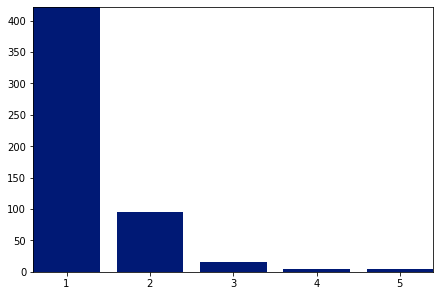

In [9]:
nstatesdist = counts(nstates, maximum(nstates))
bar(1:length(nstatesdist), nstatesdist);

In [10]:
# TODO: Check in traceroute that there is no "spurious" hops

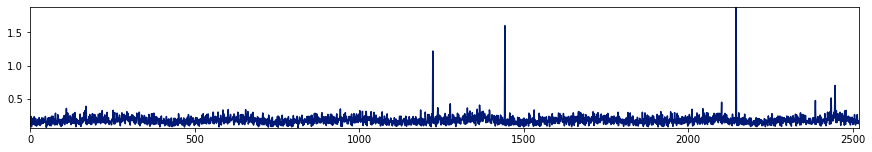

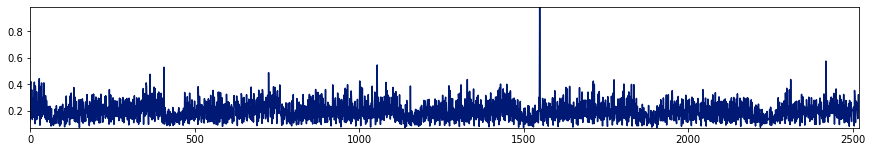

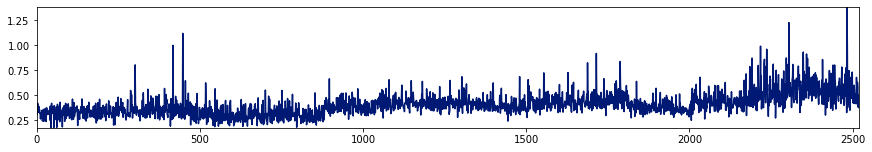

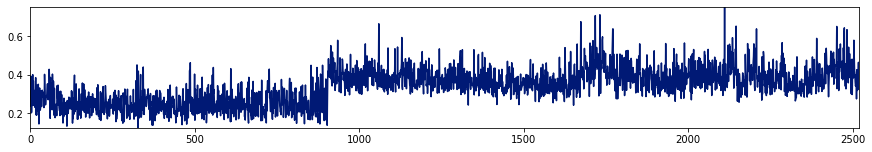

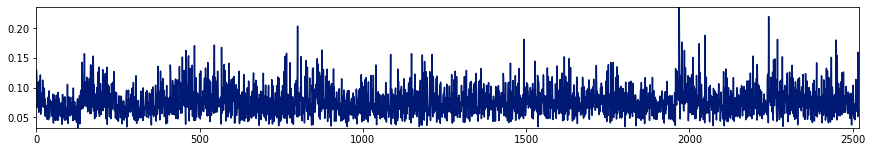

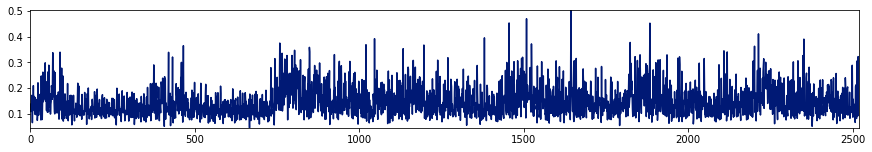

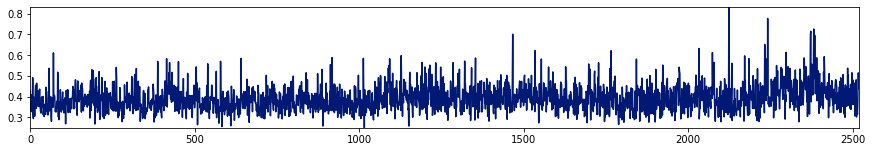

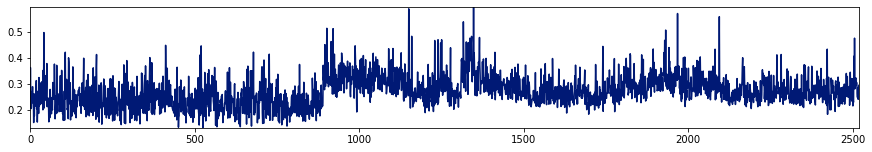

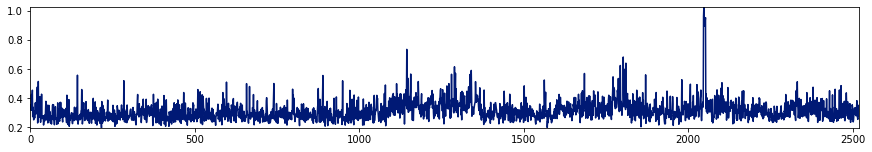

In [11]:
for m in models[nstates .>= 4]
    figure(figsize = (12,2))
    plot(coalesce.(m.data, NaN))
end

### Analysis of non-self measurements

In [12]:
# TODO: Re-do analysis with 10% of the pairs instead of 1%.
# TODO: ACF insides the states?

In [13]:
# TODO: Number of states vs. number of hops ?
# TODO: Comparer modeles appris sur 1 et 3 jours vs. les sous-sequences
# de 1 et 3 jours sur un modele appris sur 7 jours (est-ce que ca match ?).

In [14]:
files = glob("*.model.json", "../data/ping_v4_1580511600_1581116400_noself_pairs/");

In [15]:
models = map(x -> parsefile(DataSegmentationModel, x), files);

In [16]:
nstates = map(x -> size(x.model, 1), models);

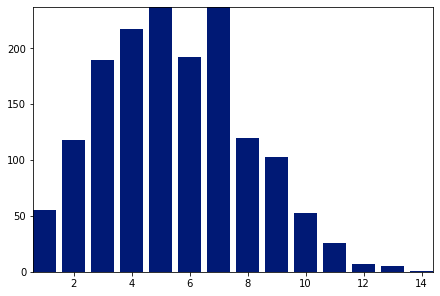

In [17]:
nstatesdist = counts(nstates, maximum(nstates))
bar(1:length(nstatesdist), nstatesdist);

In [18]:
# Compute avg. durations by states
durations, stds = [], []
for model in models
    for (state, segments) in group(segments(model.state))
        data = model.data[segments]
        push!(durations, mean(length, segments))
        push!(stds, std(skipmissing(data)))
    end
end

In [19]:
# fig, ax = subplots()
# ax.scatter(durations, stds, alpha = 0.1)
# ax.set_xscale("log")
# ax.set_yscale("log")

#### Traceroutes

In [20]:
# How many AS paths are associated to a given state?
# Cas extreme => 1 nouvel etats par timestep = exactement 1 AS/IP path par état
# How many states are associated to a given AS path?
# Cas extreme => 1 seul etat pour toute la serie = exactement 1 etat par AS/IP path
# => On veut que ces deux conditions soit le plus rapproche (= bonne segmentation)
# TODO: 3 levels : IP, router (alias resolution), AS

In [104]:
ping_traceroute_pairs = measurement_pairs(
    "../data/ping_v4_1580511600_1581116400_noself_pairs/",
    "../data/traceroute_v4_1580511600_1581116400_noself_pairs/"
);

#16453122 #16672026 #16672026 

In [ ]:
counts_ab = Int[]
counts_ba = Int[]
@showprogress for (ping_file, traceroute_file) in ping_traceroute_pairs
    try
        ping_file = "$(ping_file).model.json"
        traceroute_file = "$(splitext(traceroute_file)[1]).processed.json"

        model = parsefile(DataSegmentationModel, ping_file)
        traceroute = parsefile(Vector{TracerouteRecord}, traceroute_file)

        ping_segments = segments(model)
        traceroute_segments = segments(labelize(traceroute))

        res1 = map(x -> length(x), values(reduce(bidirectional_mapping(ping_segments, traceroute_segments)[1])))
        res2 = map(x -> length(x), values(reduce(bidirectional_mapping(ping_segments, traceroute_segments)[2])))
        push!(counts_ab, res1...)
        push!(counts_ba, res2...)
    catch e
        !(e isa SystemError) && raise(e)
        println(e.prefix)
    end
end

Progress:  66%|███████████████████████████              |  ETA: 0:01:45

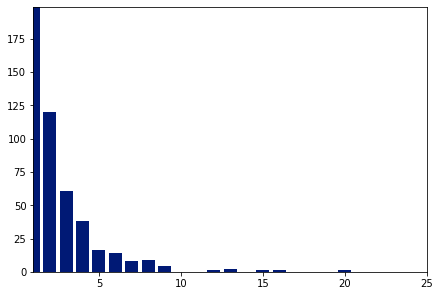

(1.0, 25.0)

In [110]:
d = counts(counts_ab, maximum(counts_ab))
bar(1:length(d), d);
xlim(1, 25)

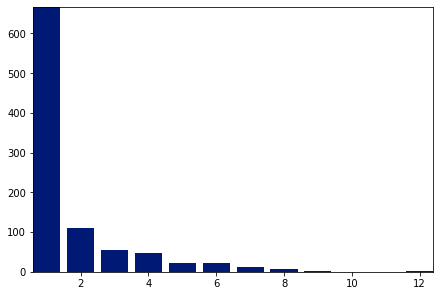

In [111]:
d = counts(counts_ba, maximum(counts_ba))
bar(1:length(d), d);

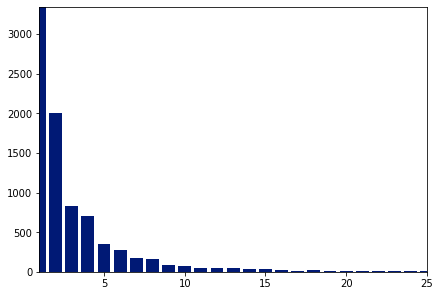

(1.0, 25.0)

In [35]:
d = counts(counts_ab, maximum(counts_ab))
bar(1:length(d), d);
xlim(1, 25)

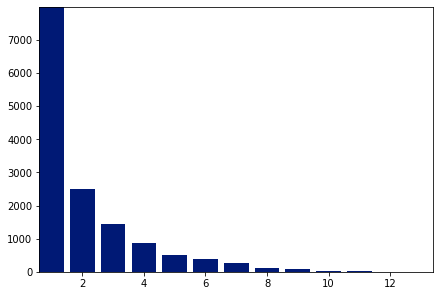

In [31]:
d = counts(counts_ba, maximum(counts_ba))
bar(1:length(d), d);

In [36]:
mean(counts_ab)

3.533444417995715

In [37]:
mean(counts_ba)

2.0871766029246346

In [40]:
ping_file, traceroute_file = ping_traceroute_pairs[1]
traceroute = TracerouteRecord.(load_traceroute(traceroute_file, asntree))[1].hops

12-element Array{Set{String},1}:
 Set(["178.237.173.217"])
 Set(["178.237.173.194"])
 Set(["178.237.173.28"])
 Set(["178.237.160.142"])
 Set(["83.217.238.13"])
 Set(["129.250.4.23"])
 Set(["129.250.7.65"])
 Set(["129.250.3.130"])
 Set(["129.250.7.85"])
 Set(["116.51.26.114"])
 Set([])
 Set(["203.174.85.106"])